# Utah
We will be analyzing the congressional district map passed in Nov, 2021 in Utah followwing the 2020 census. Currently Utah's congressional map is in litigation so we want to examine how that could have effected the 2024 U.S. House election.

## Import Required Packages

In [77]:
# For working with graphs
import networkx as nx

# For making plots
import matplotlib.pyplot as plt
import numpy as np

# For making and working with shapefiles
import geopandas as gpd
import pandas as pd

# Other necessary packages
import random
import maup

## Setting up our dataset
We want all the senate election results and voter demographics by precincts, so we will have to merge different datasets to do so. This section works through the code to create our desired shapefile dataset which we will save to github so we don't have to run the joins everytime we do analysis.

### Import Congressional Districting Plans

In [78]:
utah_cong_gdf = gpd.read_file("ut-cong-HB2004/ut-cong-HB2004.shp")

We need to confirm that there aren't any issues in the Districts, so we can use the "maup" package.

In [79]:
# Check geodataframe using maup's doctor function
maup.doctor(utah_cong_gdf)

/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/repair.py:331: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlaps = inters[inters.area > 0].make_valid()


True

We are good to use these shapefiles.

### Import and Tidy Election Data

In [80]:
# Import 2022 General Election voting data
ut_data_gdf = gpd.read_file('ut_2022_precinct_results/ut_2022.shp')
ut_data_gdf.columns

Index(['COUNTYID', 'PRECINCT', 'NAME', 'G22USSRLEE', 'G22USSIMCM',
       'G22USSLHAN', 'G22USSAWIL', 'G22USSOWRI', 'G22TREROAK', 'G22TRELBUC',
       'G22TREUHOR', 'G22TREAROG', 'geometry'],
      dtype='object')

In [81]:
# Remove the treasury election columns
ut_data_gdf = ut_data_gdf[['COUNTYID', 'PRECINCT', 'NAME', 'G22USSRLEE', 'G22USSIMCM',
       'G22USSLHAN', 'G22USSAWIL', 'G22USSOWRI', 'geometry']]

# Check that we've kept the right stuff
ut_data_gdf

,COUNTYID,PRECINCT,NAME,G22USSRLEE,G22USSIMCM,G22USSLHAN,G22USSAWIL,G22USSOWRI,geometry
0,25,EM412,Eagle Mountain 412,362,228,23,5,0,"POLYGON ((-111.96891 40.36210, -111.96759 40.3..."
1,3,RCH01:I,Richmond 01 I,356,127,14,10,5,"POLYGON ((-111.80153 41.94708, -111.80106 41.9..."
2,6,BO23:I-S-,Bountiful 23,104,135,15,5,0,"POLYGON ((-111.88590 40.87474, -111.88575 40.8..."
3,26,550,550 Wallsburg Town,72,33,4,1,0,"POLYGON ((-111.41437 40.39193, -111.41440 40.3..."
4,26,201,201 Heber City W,109,71,2,1,0,"POLYGON ((-111.43073 40.50691, -111.42855 40.5..."
...,...,...,...,...,...,...,...,...,...
2864,12,NE3,Nephi 3,380,55,12,12,0,"MULTIPOLYGON (((-111.83615 39.71148, -111.8380..."
2865,23,WE01,Wendover 01,53,18,5,3,0,"POLYGON ((-112.82426 40.99005, -112.82242 40.9..."
2866,23,EC02,Erda City 02,169,54,14,1,0,"POLYGON ((-112.33305 40.65952, -112.33090 40.6..."
2867,16,1:1,#1 Marysvale,218,47,2,2,0,"POLYGON ((-112.20527 38.51218, -112.20527 38.5..."


Now we will assign precincts to congressional districts.

In [82]:
# Keep Precinct CRS
utah_cong_gdf = utah_cong_gdf.set_crs("EPSG:4326", allow_override=True)

precincts_to_districts = maup.assign(ut_data_gdf.geometry, utah_cong_gdf.geometry)
precincts_to_districts

/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/intersections.py:47: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df[df.area > area_cutoff].reset_index(drop=True)
/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/intersections.py:48: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometries = geometries[geometries.area > area_cutoff]
/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/assign.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return assign_to_max(intersections(sources, targets, area_cutoff=0).area)

0       3
1       0
2       1
3       2
4       2
       ..
2864    1
2865    1
2866    1
2867    1
2868    1
Length: 2869, dtype: int64

In [83]:
# Check that the assingment went smootly: that all precints have an assigned congressional district
ut_data_gdf[precincts_to_districts.isna()]

,COUNTYID,PRECINCT,NAME,G22USSRLEE,G22USSIMCM,G22USSLHAN,G22USSAWIL,G22USSOWRI,geometry


Now we will add this assignment columns to the election data geodataframe so that we know what congressional district the precinct is in for the 2021 plan.

In [84]:
ut_data_gdf["DIST2021"] = precincts_to_districts
ut_data_gdf

,COUNTYID,PRECINCT,NAME,G22USSRLEE,G22USSIMCM,G22USSLHAN,G22USSAWIL,G22USSOWRI,geometry,DIST2021
0,25,EM412,Eagle Mountain 412,362,228,23,5,0,"POLYGON ((-111.96891 40.36210, -111.96759 40.3...",3
1,3,RCH01:I,Richmond 01 I,356,127,14,10,5,"POLYGON ((-111.80153 41.94708, -111.80106 41.9...",0
2,6,BO23:I-S-,Bountiful 23,104,135,15,5,0,"POLYGON ((-111.88590 40.87474, -111.88575 40.8...",1
3,26,550,550 Wallsburg Town,72,33,4,1,0,"POLYGON ((-111.41437 40.39193, -111.41440 40.3...",2
4,26,201,201 Heber City W,109,71,2,1,0,"POLYGON ((-111.43073 40.50691, -111.42855 40.5...",2
...,...,...,...,...,...,...,...,...,...,...
2864,12,NE3,Nephi 3,380,55,12,12,0,"MULTIPOLYGON (((-111.83615 39.71148, -111.8380...",1
2865,23,WE01,Wendover 01,53,18,5,3,0,"POLYGON ((-112.82426 40.99005, -112.82242 40.9...",1
2866,23,EC02,Erda City 02,169,54,14,1,0,"POLYGON ((-112.33305 40.65952, -112.33090 40.6...",1
2867,16,1:1,#1 Marysvale,218,47,2,2,0,"POLYGON ((-112.20527 38.51218, -112.20527 38.5...",1


### Join Census Demographic Data with the Precinct Voting Data
The census data provides up data about voter demographics by blocks. However, we want it by precincts since our voting data is grouped by precincts.

In [85]:
# Import the Census Data, which is in a .csv format
ut_blocks = pd.read_csv('DECENNIALPL2020_P1_Utah/DECENNIALPL2020.P1-Data.csv')

# Remove first row
ut_blocks = ut_blocks.iloc[1:]

# Reset the index
ut_blocks.reset_index(drop=True, inplace=True)

# Edit the geo id column
ut_blocks['GEO_ID'] = ut_blocks['GEO_ID'].str[9:]

# Keep only the columns counting population of one race
ut_blocks = ut_blocks[["GEO_ID", "NAME", "P1_001N", "P1_002N", "P1_003N", "P1_004N", "P1_005N", "P1_006N", "P1_007N", "P1_008N"]]

/var/folders/2w/nf45dfcn5c9cqf954vr1lz3r0000gn/T/ipykernel_66527/2611682946.py:2: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72) have mixed types. Specify dtype option on import or set low_memory=False.
  ut_blocks = pd.read_csv('DECENNIALPL2020_P1_Utah/DECENNIALPL2020.P1-Data.csv')


In [86]:
ut_blocks

,GEO_ID,NAME,P1_001N,P1_002N,P1_003N,P1_004N,P1_005N,P1_006N,P1_007N,P1_008N
0,490011001001000,"Block 1000, Block Group 1, Census Tract 1001, ...",0,0,0,0,0,0,0,0
1,490011001001001,"Block 1001, Block Group 1, Census Tract 1001, ...",0,0,0,0,0,0,0,0
2,490011001001002,"Block 1002, Block Group 1, Census Tract 1001, ...",0,0,0,0,0,0,0,0
3,490011001001003,"Block 1003, Block Group 1, Census Tract 1001, ...",0,0,0,0,0,0,0,0
4,490011001001004,"Block 1004, Block Group 1, Census Tract 1001, ...",0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
71202,490572112025022,"Block 5022, Block Group 5, Census Tract 2112.0...",58,53,47,3,1,0,0,2
71203,490572112025023,"Block 5023, Block Group 5, Census Tract 2112.0...",110,104,101,1,0,0,0,2
71204,490572112025024,"Block 5024, Block Group 5, Census Tract 2112.0...",59,45,44,0,0,1,0,0
71205,490572112025025,"Block 5025, Block Group 5, Census Tract 2112.0...",57,50,45,0,0,3,0,2


In [87]:
# Import the shapefile block data
ut_block_gdf = gpd.read_file("tl_2022_49_tabblock20/tl_2022_49_tabblock20.shp")

In [88]:
ut_block_gdf.columns

Index(['STATEFP20', 'COUNTYFP20', 'TRACTCE20', 'BLOCKCE20', 'GEOID20',
       'NAME20', 'MTFCC20', 'UR20', 'UACE20', 'UATYPE20', 'FUNCSTAT20',
       'ALAND20', 'AWATER20', 'INTPTLAT20', 'INTPTLON20', 'HOUSING20', 'POP20',
       'geometry'],
      dtype='object')

In [89]:
ut_block_gdf = ut_block_gdf[['STATEFP20', 'COUNTYFP20', 'TRACTCE20', 'BLOCKCE20', 'GEOID20', 'NAME20', 'POP20', 'geometry']]
ut_block_gdf

,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,NAME20,POP20,geometry
0,49,011,125408,2037,490111254082037,Block 2037,0,"POLYGON ((-112.18636 41.14375, -112.18177 41.1..."
1,49,027,974200,3207,490279742003207,Block 3207,0,"POLYGON ((-113.64279 39.32295, -113.64268 39.3..."
2,49,003,960400,1053,490039604001053,Block 1053,25,"POLYGON ((-112.48968 41.56186, -112.48966 41.5..."
3,49,045,130800,1000,490451308001000,Block 1000,0,"POLYGON ((-112.44779 40.62190, -112.44763 40.6..."
4,49,045,130600,2322,490451306002322,Block 2322,0,"POLYGON ((-114.04544 40.49485, -114.04542 40.4..."
...,...,...,...,...,...,...,...,...
71202,49,025,130100,1358,490251301001358,Block 1358,1,"POLYGON ((-112.80048 37.41168, -112.80043 37.4..."
71203,49,011,126405,1000,490111264051000,Block 1000,112,"POLYGON ((-111.87462 40.85381, -111.87458 40.8..."
71204,49,049,010600,1163,490490106001163,Block 1163,2,"POLYGON ((-111.82206 40.00767, -111.82203 40.0..."
71205,49,053,270101,1042,490532701011042,Block 1042,0,"POLYGON ((-113.22829 37.45455, -113.22811 37.4..."


In [90]:
# Now we join the shapefile block data with the census data
ut_block_gdf = ut_block_gdf.merge(ut_blocks, left_on = ["GEOID20"], right_on = ["GEO_ID"], how = "left")

In [91]:
ut_block_gdf.head()

,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,NAME20,POP20,geometry,GEO_ID,NAME,P1_001N,P1_002N,P1_003N,P1_004N,P1_005N,P1_006N,P1_007N,P1_008N
0,49,011,125408,2037,490111254082037,Block 2037,0,"POLYGON ((-112.18636 41.14375, -112.18177 41.1...",490111254082037,"Block 2037, Block Group 2, Census Tract 1254.0...",0,0,0,0,0,0,0,0
1,49,027,974200,3207,490279742003207,Block 3207,0,"POLYGON ((-113.64279 39.32295, -113.64268 39.3...",490279742003207,"Block 3207, Block Group 3, Census Tract 9742, ...",0,0,0,0,0,0,0,0
2,49,003,960400,1053,490039604001053,Block 1053,25,"POLYGON ((-112.48968 41.56186, -112.48966 41.5...",490039604001053,"Block 1053, Block Group 1, Census Tract 9604, ...",25,25,20,0,0,4,0,1
3,49,045,130800,1000,490451308001000,Block 1000,0,"POLYGON ((-112.44779 40.62190, -112.44763 40.6...",490451308001000,"Block 1000, Block Group 1, Census Tract 1308, ...",0,0,0,0,0,0,0,0
4,49,045,130600,2322,490451306002322,Block 2322,0,"POLYGON ((-114.04544 40.49485, -114.04542 40.4...",490451306002322,"Block 2322, Block Group 2, Census Tract 1306, ...",0,0,0,0,0,0,0,0


This shapefile has all the census data by block shapefile. Now we want to aggregate up the block demographic data to be precinct data to then join to the precinct voting data.

In [93]:
# We now need to agregate the block data up to the precinct data
pop_cols = ['P1_001N', 'P1_002N', 'P1_003N', "P1_004N", "P1_005N", "P1_006N", "P1_007N", "P1_008N"]

# How blocks are inputted into the precinct shapefile dataframe
ut_block_gdf = ut_block_gdf.set_crs("EPSG:4326", allow_override=True)
blocks_to_precincts_assignment = maup.assign(ut_block_gdf.geometry, ut_data_gdf.geometry)

# We need to get all the data types of P1 to ints
for item in pop_cols:
    ut_block_gdf[item] = pd.to_numeric(ut_block_gdf[item])

ut_data_gdf[pop_cols] = ut_block_gdf[pop_cols].groupby(blocks_to_precincts_assignment).sum()

/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/intersections.py:47: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df[df.area > area_cutoff].reset_index(drop=True)
/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/intersections.py:48: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometries = geometries[geometries.area > area_cutoff]
/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/assign.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return assign_to_max(intersections(sources, targets, area_cutoff=0).area)

In [94]:
# Check that we didn't loose any population
ut_data_gdf[pop_cols].head()

print(ut_block_gdf[pop_cols].sum())

print(ut_data_gdf[pop_cols].sum())

P1_001N    3271616
P1_002N    2992603
P1_003N    2573413
P1_004N      40058
P1_005N      41644
P1_006N      80438
P1_007N      36930
P1_008N     220120
dtype: int64
P1_001N    3271590.0
P1_002N    2992586.0
P1_003N    2573397.0
P1_004N      40058.0
P1_005N      41644.0
P1_006N      80438.0
P1_007N      36930.0
P1_008N     220119.0
dtype: float64


In [95]:
ut_data_gdf

,COUNTYID,PRECINCT,NAME,G22USSRLEE,G22USSIMCM,G22USSLHAN,G22USSAWIL,G22USSOWRI,geometry,DIST2021,P1_001N,P1_002N,P1_003N,P1_004N,P1_005N,P1_006N,P1_007N,P1_008N
0,25,EM412,Eagle Mountain 412,362,228,23,5,0,"POLYGON ((-111.96891 40.36210, -111.96759 40.3...",3,2726.0,2461.0,2235.0,22.0,23.0,25.0,33.0,123.0
1,3,RCH01:I,Richmond 01 I,356,127,14,10,5,"POLYGON ((-111.80153 41.94708, -111.80106 41.9...",0,1602.0,1563.0,1490.0,3.0,14.0,1.0,5.0,50.0
2,6,BO23:I-S-,Bountiful 23,104,135,15,5,0,"POLYGON ((-111.88590 40.87474, -111.88575 40.8...",1,1107.0,1020.0,915.0,9.0,9.0,9.0,38.0,40.0
3,26,550,550 Wallsburg Town,72,33,4,1,0,"POLYGON ((-111.41437 40.39193, -111.41440 40.3...",2,290.0,284.0,279.0,2.0,0.0,0.0,0.0,3.0
4,26,201,201 Heber City W,109,71,2,1,0,"POLYGON ((-111.43073 40.50691, -111.42855 40.5...",2,718.0,651.0,544.0,10.0,2.0,10.0,0.0,85.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2610,12,NE3,Nephi 3,380,55,12,12,0,"MULTIPOLYGON (((-111.83615 39.71148, -111.8380...",1,345.0,313.0,300.0,0.0,4.0,4.0,0.0,5.0
2611,23,WE01,Wendover 01,53,18,5,3,0,"POLYGON ((-112.82426 40.99005, -112.82242 40.9...",1,1115.0,870.0,449.0,9.0,30.0,4.0,2.0,376.0
2612,23,EC02,Erda City 02,169,54,14,1,0,"POLYGON ((-112.33305 40.65952, -112.33090 40.6...",1,1362.0,1268.0,1211.0,6.0,8.0,6.0,9.0,28.0
2613,16,1:1,#1 Marysvale,218,47,2,2,0,"POLYGON ((-112.20527 38.51218, -112.20527 38.5...",1,391.0,380.0,378.0,0.0,1.0,0.0,0.0,1.0


In [96]:
# Check to see if there are na values
ut_data_gdf[ut_data_gdf["P1_001N"].isna()]

,COUNTYID,PRECINCT,NAME,G22USSRLEE,G22USSIMCM,G22USSLHAN,G22USSAWIL,G22USSOWRI,geometry,DIST2021,P1_001N,P1_002N,P1_003N,P1_004N,P1_005N,P1_006N,P1_007N,P1_008N
39,3,RVH02:U1,River Heights 02 U1,2,0,0,0,0,"POLYGON ((-111.82015 41.72575, -111.82037 41.7...",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150,6,KA30:IBCB,Kaysville 30,0,4,0,0,0,"POLYGON ((-111.94083 41.00738, -111.94088 41.0...",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
151,6,KA31:I-C-,Kaysville 31,28,9,0,0,0,"POLYGON ((-111.94316 41.00522, -111.94315 41.0...",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
289,3,PRO03:U1,Providence 03 U1,2,0,0,0,0,"POLYGON ((-111.83044 41.70074, -111.83044 41.7...",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
401,23,SP04:2,Stansbury Park 04-2,5,5,0,0,0,"POLYGON ((-112.31602 40.63080, -112.31596 40.6...",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
509,3,SMI03:U,Smithfield 03 U,2,0,0,0,0,"POLYGON ((-111.77627 41.83586, -111.77605 41.8...",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
850,25,PA414,Payson 414,0,1,0,0,0,"POLYGON ((-111.74434 40.01087, -111.74441 40.0...",3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1085,25,SA408,Salem 408,0,0,0,1,0,"POLYGON ((-111.64862 40.04928, -111.65180 40.0...",3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1132,3,LOG21:CSD,Logan 21 CSD,0,3,0,0,0,"POLYGON ((-111.80428 41.72860, -111.80423 41.7...",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1912,18,SAN007,Sandy 007,9,4,0,0,0,"POLYGON ((-111.83211 40.60155, -111.83211 40.6...",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's remove the rows where there were no votes for any Senate candidate.

In [71]:
# Create a mask for rows where the sum of the three columns is not zero
mask = (ut_data_gdf['G22USSRLEE'] + ut_data_gdf['G22USSIMCM'] + ut_data_gdf['G22USSLHAN'] + ut_data_gdf['G22USSAWIL'] + ut_data_gdf['G22USSOWRI']) != 0
# Use the mask to filter out the rows where the sum is zero
ut_data_gdf = ut_data_gdf[mask].reset_index(drop=True)

In [74]:
# Now let's check how many precincts are demographic na values
ut_data_gdf[ut_data_gdf["P1_001N"].isna()]

,COUNTYID,PRECINCT,NAME,G22USSRLEE,G22USSIMCM,G22USSLHAN,G22USSAWIL,G22USSOWRI,geometry,DIST2021,P1_001N,P1_002N,P1_003N,P1_004N,P1_005N,P1_006N,P1_007N,P1_008N
39,3,RVH02:U1,River Heights 02 U1,2,0,0,0,0,"POLYGON ((-111.82015 41.72575, -111.82037 41.7...",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150,6,KA30:IBCB,Kaysville 30,0,4,0,0,0,"POLYGON ((-111.94083 41.00738, -111.94088 41.0...",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
151,6,KA31:I-C-,Kaysville 31,28,9,0,0,0,"POLYGON ((-111.94316 41.00522, -111.94315 41.0...",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
279,6,LA59:U-N-,Layton 59,3,2,0,0,0,"POLYGON ((-111.90161 41.07881, -111.90153 41.0...",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
289,3,PRO03:U1,Providence 03 U1,2,0,0,0,0,"POLYGON ((-111.83044 41.70074, -111.83044 41.7...",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
401,23,SP04:2,Stansbury Park 04-2,5,5,0,0,0,"POLYGON ((-112.31602 40.63080, -112.31596 40.6...",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
509,3,SMI03:U,Smithfield 03 U,2,0,0,0,0,"POLYGON ((-111.77627 41.83586, -111.77605 41.8...",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
843,25,LE403,Lehi 403,1,0,0,0,0,"POLYGON ((-111.92209 40.40950, -111.92208 40.4...",3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
850,25,PA414,Payson 414,0,1,0,0,0,"POLYGON ((-111.74434 40.01087, -111.74441 40.0...",3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1085,25,SA408,Salem 408,0,0,0,1,0,"POLYGON ((-111.64862 40.04928, -111.65180 40.0...",3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
# Save data to a shapefile so we don't have to join all the data again
ga_data_gdf.to_file("./save-new-data/GA-election-census-data-by-precincts.shp")

NameError: name 'ga_data_gdf' is not defined

## Check that the joins went smoothly

In [ ]:
# Read in our saved dataframe
ga_data_gdf = gpd.read_file("save-new-data/GA-election-census-data-by-precincts.shp")

<Axes: >

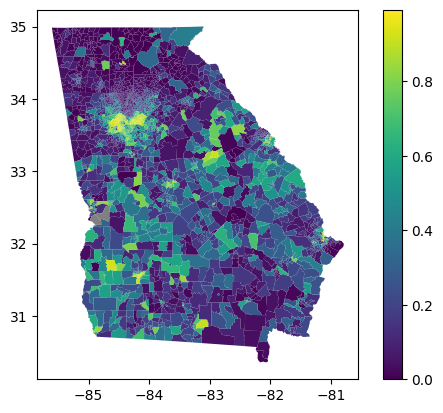

In [ ]:
# Plot the black population percentage by precincts
ga_data_gdf['b_frac'] = pd.to_numeric(ga_data_gdf['P1_004N'])/pd.to_numeric(ga_data_gdf['P1_001N'])
ga_data_gdf.plot(column = 'b_frac', missing_kwds = {"color":"grey"}, legend=True)

<Axes: >

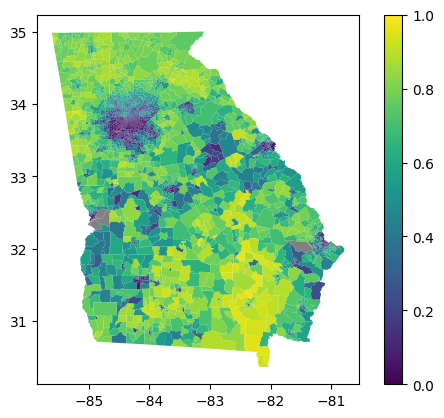

In [ ]:
# Plot the senate republican votes by precincts
ga_data_gdf['senate_r_perc'] = pd.to_numeric(ga_data_gdf['G22USSRWAL'])/pd.to_numeric(ga_data_gdf["G22USSRWAL"] + ga_data_gdf["G22USSDWAR"] + ga_data_gdf["G22USSLOLI"])
ga_data_gdf.plot(column = 'senate_r_perc', missing_kwds = {"color":"grey"}, legend=True)